## Required Pkgs

In [5]:
import sys
import numpy as np
import pandas as pd
# np.set_printoptions(threshold=sys.maxsize) # to display the entire array
# Rasdaman

from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)

db_connector.open() # connection open


# Geospatial Pkgs 
import gdal
from gdalconst import *
from osgeo import osr

import shapefile as sh
import geopandas as gpd
from shapely.geometry import LineString, MultiPolygon, Polygon, box, MultiPoint, Point
from shapely import wkt
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class


# Visualizations
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

from platform import python_version

print(python_version())

output_notebook()

3.8.10


Loading BokehJS ...

## Section 1. Functions f(x)

In [6]:
def GetGeoInfo(FileName):
    SourceDS = gdal.Open(FileName, GA_ReadOnly)
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())    
    
    return GeoT, Projection

In [7]:
def query2array(query):
    result = query_executor.execute_read(query) 
    numpy_array = result.to_array()
    print(numpy_array.shape)
    
    return numpy_array   

In [8]:
def arrayDISP(query):
    result = query_executor.execute_read(query) 
    numpy_array = result.to_array()
    plt.imshow(numpy_array, cmap = "inferno")
    plt.colorbar()
    plt.show()
    print(numpy_array.shape)
    print(type(numpy_array))

In [9]:
def deleteNULLval(dataARRAY, valNULL):
    dataARRAY = np.ma.masked_equal(dataARRAY,valNULL)

    plt.imshow(dataARRAY, cmap = "inferno")
    plt.colorbar()
    plt.show()
    
    return dataARRAY

In [10]:
def latlong2wkt(lat_longs): #list of latlong
    plygon = Polygon(lat_longs)
    
    return plygon.wkt

In [11]:
def wktDisplay(polygon):
    # Create plot object just like standard WKTPlot class
    plot = OpenStreetMapsPlot("Open Street Map Plot", 
                              height=600,
                              width=600,
                              disable_mercator=False)
    plot.add_shape(polygon, fill_alpha=0.5, fill_color="firebrick")

    plot.show()

In [12]:
def get_geometries(top_left, bottom_right, spacing):
    polygons = []
    points = []
    xmin = top_left[0]
    xmax = bottom_right[0]
    ymax = top_left[1]
    y = bottom_right[1]
    i = -1
    while True:
        if y > ymax:
            break
        x = xmin

        while True:
            if x > xmax:
                break
            
            #components for polygon grid
            polygon = box(x, y, x+spacing, y+spacing)
            polygons.append(polygon)

            #components for point grid
            point = Point(x, y)
            points.append(point)
            i = i + 1
            x = x + spacing

        y = y + spacing
    return polygons, points

## Section 2. Exploratory Data Analysis (EDA)

### Existing Dataset

In [8]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
print(collection_list)

['AIR_TEMP_03', 'AIR_TEMP_X', 'output1', 'LST_03_GeoTIFF', 'AIR_TEMP_02', 'AIR_TEMP_01']


### NetCDF 

In [9]:
dbinfo = query_executor.execute_read('select dbinfo(c) from AIR_TEMP_X as c')
print(dbinfo)
dim = query_executor.execute_read("select sdom(c) from AIR_TEMP_X as c")         
print(dim)

{
 "oid": "3073",
 "baseType": "marray <float, [*:*,*:*,*:*]>",
 "setTypeName": "AIR_TEMP_X_Set",
 "mddTypeName": "AIR_TEMP_X_Array",
 "tileNo": "1382",
 "totalSize": "1430784000",
 "tiling": {
	"tilingScheme": "aligned",
	"tileSize": "4194304",
	"tileConfiguration": "[0:0,0:359,0:719]"
 },
 "index": {
	"type": "rpt_index",
	"PCTmax": "4096",
	"PCTmin": "2048"
 }
}
[0:1379,0:359,0:719]


In [10]:
q1 = "select m[50, 0:1 , 0:1] from AIR_TEMP_X as m"
query2array(q1)

(2, 2)


array([[-9.96921e+36, -9.96921e+36],
       [-9.96921e+36, -9.96921e+36]], dtype=float32)

In [11]:
q2 = "select m[50, 0:* , 0:*] from AIR_TEMP_X as m"
query2array(q2)

(360, 720)


array([[-9.96921e+36, -9.96921e+36, -9.96921e+36, ..., -9.96921e+36,
        -9.96921e+36, -9.96921e+36],
       [-9.96921e+36, -9.96921e+36, -9.96921e+36, ..., -9.96921e+36,
        -9.96921e+36, -9.96921e+36],
       [-9.96921e+36, -9.96921e+36, -9.96921e+36, ..., -9.96921e+36,
        -9.96921e+36, -9.96921e+36],
       ...,
       [-5.22000e+01, -5.22000e+01, -5.22000e+01, ..., -5.21000e+01,
        -5.21000e+01, -5.22000e+01],
       [-5.25000e+01, -5.25000e+01, -5.25000e+01, ..., -5.25000e+01,
        -5.25000e+01, -5.25000e+01],
       [-5.34000e+01, -5.34000e+01, -5.34000e+01, ..., -5.34000e+01,
        -5.34000e+01, -5.34000e+01]], dtype=float32)

In [12]:
worldDATA = query2array(q2)

(360, 720)


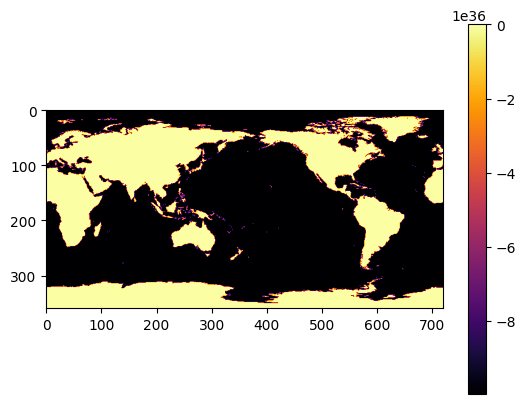

<class 'numpy.ndarray'>


In [13]:
arrayDISP(q2)

(360, 720)


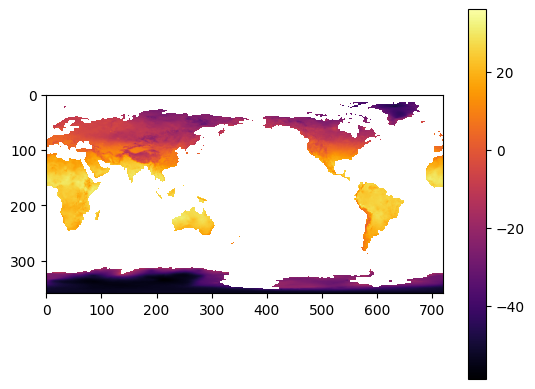

In [14]:
arrayDATA = query2array(q2)
arrayCLEAN = deleteNULLval(arrayDATA,-9.96921e+36)

In [16]:
print(arrayCLEAN)
print(arrayCLEAN.shape)

[[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

### GeoTIFF 

Information using gdal lib 

Source: https://drr.ikcest.org/tutorial/k8022

##### Let’s take a look at how to get the basic information of the data set, using the following functions and attributes.

``rds.GetDescription()``: Get the description of the raster
    
``rds.GetMetadata()`` :  metadata information of the most commonly used GeoTIFF file

``rds.RasterCount`` : Get the number of bands in the raster dataset

``rds.RasterXSize`` : the width of the raster data (the number of pixels in the X direction)

``rds.RasterYSize`` : height of raster data (number of pixels in the Y direction)

``rds.GetGeoTransform()`` : The six parameters of the raster data.

``GetProjection()`` : projection of raster data


In [11]:
rds = gdal.Open('/home/arkaghosh/Downloads/RAS_DATA/MOD11A1.006_LST_Night_1km_doy20170101_aid0001.tif')
info = gdal.Info(rds, deserialize=True)
print(info) 

Driver: GTiff/GeoTIFF
Files: /home/arkaghosh/Downloads/RAS_DATA/MOD11A1.006_LST_Night_1km_doy20170101_aid0001.tif
       /home/arkaghosh/Downloads/RAS_DATA/MOD11A1.006_LST_Night_1km_doy20170101_aid0001.tif.aux.xml
Size is 43099, 20757
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.158333317244455,88.316666658735613)
Pixel Size = (0.008333333332585,-0.008333333332585)
Metadata:
  add_offset=0
  AREA_OR_POINT=Area
  scale_factor=0.02
  units=Kelvin
Image Structure Me

In [12]:
scale_factor = 0.02
srcband =rds.GetRasterBand(1)
srcband.ComputeStatistics(0)
print("[ MIN ] = ", scale_factor*srcband.GetMinimum())
print("[ MAX ] = ", scale_factor*srcband.GetMaximum())

[ MIN ] =  216.08
[ MAX ] =  338.5


In [13]:
GetGeoInfo('/home/arkaghosh/Downloads/RAS_DATA/MOD11A1.006_LST_Night_1km_doy20170101_aid0001.tif')

((-179.15833331724446,
  0.008333333332584979,
  0.0,
  88.31666665873561,
  0.0,
  -0.008333333332584979),
 <osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x7fcd127dda50> >)

### GeoTIFF in Rasdaman

In [15]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
print(collection_list)

['AIR_TEMP_01', 'output1', 'AIR_TEMP_02', 'AIR_TEMP_X', 'AIR_TEMP_03', 'LST_03_GeoTIFF']


In [16]:
dbinfo = query_executor.execute_read('select dbinfo(w) from LST_03_GeoTIFF as w')
print(dbinfo)
dim = query_executor.execute_read("select sdom(w) from LST_03_GeoTIFF as w")         
print(dim)

{
 "oid": "5121",
 "baseType": "marray <long, [*:*,*:*,*:*]>",
 "setTypeName": "MyCoverage_Set",
 "mddTypeName": "MyCoverage_Array",
 "tileNo": "2588",
 "totalSize": "10735271316",
 "tiling": {
	"tilingScheme": "aligned",
	"tileSize": "4194304",
	"tileConfiguration": "[0:*,0:43098,0:20756]"
 },
 "index": {
	"type": "rpt_index",
	"PCTmax": "4096",
	"PCTmin": "2048"
 }
}
[0:2,0:43098,0:20756]


In [17]:
q3 = "select w[1, 20000:40000, 0:15000] from LST_03_GeoTIFF as w"
query2array(q3)

(20001, 15001)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

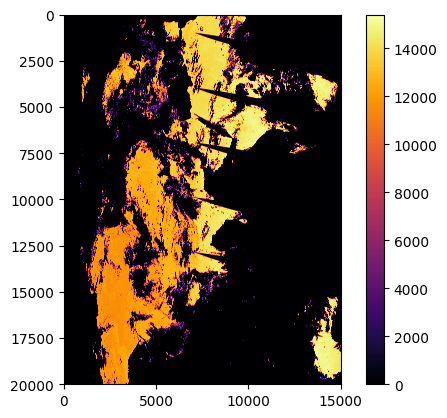

<class 'numpy.ndarray'>


In [11]:
arrayDISP(q3)

In [12]:
arrayDATA_geoTIFF = query2array(q3)
print(arrayDATA_geoTIFF)

(20001, 15001)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


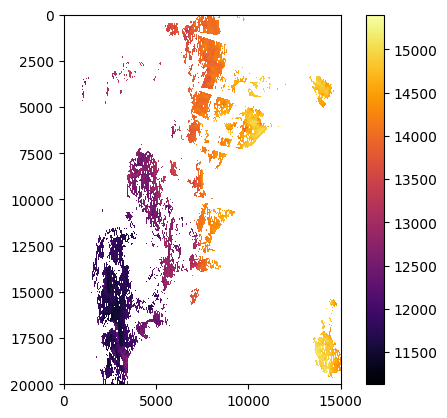

In [13]:
arrayCLEAN02 = deleteNULLval(arrayDATA_geoTIFF,0)

In [16]:
arrayCLEAN02

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=int32)

In [20]:
arrayCLEAN02.shape

(20001, 15001)

In [33]:
import numpy.ma as ma

arrayCLEAN02 = ma.getdata(arrayCLEAN02, subok=False)

In [ ]:
# arr = arrayCLEAN02.compressed() #1D aray of valid data pixels

In [38]:
print(arrayCLEAN02)
print(arrayCLEAN02.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOStream.flush timed out


In [13]:
q4 = "select w[1, 0:4000, 0:*] from LST_03_GeoTIFF as w"
worldDATA = query2array(q4)
print(worldDATA)

(4001, 20757)
[[    0     0     0 ... 12827 12796 12785]
 [    0     0     0 ... 12827 12792 12785]
 [    0     0     0 ... 12829 12792 12785]
 ...
 [    0     0     0 ... 13219 13220 13224]
 [    0     0     0 ... 13219 13224 13224]
 [    0     0     0 ... 13219 13224 13224]]


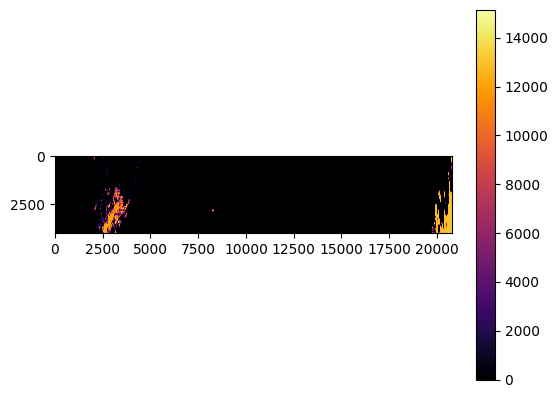

<class 'numpy.ndarray'>


In [14]:
arrayDISP(q4)

In [9]:
q5 = "select w[1, 0:*, 0:12000] from LST_03_GeoTIFF as w"
worldDATA = query2array(q5)
# print(worldDATA)

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 478, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 378, in rassrvr_keep_alive
    resp = stub.KeepAlive(make_rassrvr_keep_alive_req(client_uuid, session_id),
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "recvmsg:Connection reset by peer"
	debug_error_string = "UNKNO

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "recvmsg:Connection reset by peer"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:7002 {created_time:"2023-02-22T19:48:20.915151711+05:30", grpc_status:14, grpc_message:"recvmsg:Connection reset by peer"}"
>

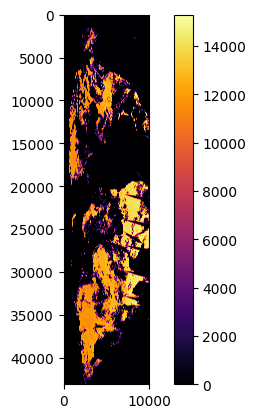

<class 'numpy.ndarray'>


In [9]:
arrayDISP(q5)

In [10]:
worldDATA.shape

(43099, 5001)

In [9]:
q5 = "select w[1, 0:*, 0:*] from LST_03_GeoTIFF as w"
worldDATA = query2array(q5)
print(worldDATA)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Broken pipe"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:7002 {created_time:"2023-02-22T18:29:44.426892851+05:30", grpc_status:14, grpc_message:"Broken pipe"}"
>

## Section 3: Vector Data To wkt Format

* [Wicket- A wkt read/write](http://arthur-e.github.io/Wicket/sandbox-gmaps3.html)
* [Generate WKT from Lat Long Coordinates](https://www.markhneedham.com/blog/2022/01/14/python-generate-wkt-lat-long-coordinates/)

In [36]:
AREA_OF_INTEREST = [
    (38.6855098, -12.4804688),
    (40.0444376, 1.7578125),
    (54.8766067, 6.3281250),
    (38.6855098, -12, .4804688)
]

AREA_OF_INTEREST

[(38.6855098, -12.4804688),
 (40.0444376, 1.7578125),
 (54.8766067, 6.328125),
 (38.6855098, -12, 0.4804688)]

In [37]:
latlong2wkt(AREA_OF_INTEREST)

ValueError: Inconsistent coordinate dimensionality

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 478, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 73, in rasmgr_keep_alive
    return stub.KeepAlive(make_rasmgr_keep_alive_req(cuuid), _TIMEOUT_SECONDS)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "pThe client with client ID ec8053f3-35e1-463a-b586-91fa66ddcfa2 does

In [24]:
AREA_OF_INTEREST_POLYGON = "POLYGON((5.493164062500001 47.724544549099676,5.405273437499999 37.47485808497102,11.249999999999998 37.54457732085582,14.941406249999996 36.173356935221605,18.632812499999996 39.368279149160145,19.116210937500004 40.41349604970196,17.5341796875 41.343824581185714,13.0078125 44.59046718130884,13.359375 45.49094569262732,13.359375 47.665387356326534,5.493164062500001 47.724544549099676))"
AREA_OF_INTEREST_POLYGON

'POLYGON((5.493164062500001 47.724544549099676,5.405273437499999 37.47485808497102,11.249999999999998 37.54457732085582,14.941406249999996 36.173356935221605,18.632812499999996 39.368279149160145,19.116210937500004 40.41349604970196,17.5341796875 41.343824581185714,13.0078125 44.59046718130884,13.359375 45.49094569262732,13.359375 47.665387356326534,5.493164062500001 47.724544549099676))'

In [25]:
wktDisplay(AREA_OF_INTEREST_POLYGON)

In [26]:
polygon2 = "polygon((0 0, 20 -10 , 60 20 , 30 40, 0 0))" #(y0 x0, y1 x1 ...., yn xn, y0 x0) clockwise
wktDisplay(polygon2)

In [27]:
polygon3 = "POLYGON ((35 10, 45 45, 15 40, 10 20, 35 10), (20 30, 35 35, 30 20, 20 30), (26 26, 30 30, 27 29, 26 26))"
wktDisplay(polygon3)

In [28]:
polygon4 = 'POLYGON((17.564247434051406 54.446991320181255,16.311806027801406 54.061910892199705,15.575722043426405 53.37933926382691,15.377968137176405 52.79871812523439,15.575722043426405 51.98076121960815,15.619667355926405 51.15448239676194,16.696327512176406 50.94037053252475,17.871864621551406 50.47422670556861,18.761757199676406 50.27102433369101,21.54709245171919 50.3018762188395,22.28317643609419 50.31590902034586,23.19504167046919 51.019189209157204,22.65671159234419 52.08481472438036,22.79953385796919 52.86108007657073,22.48237015280161 53.76537437170607,22.24067093405161 54.11458487224089,20.402314605750536 54.24318115411181,18.908173980750536 54.09526092933704,18.007295074500536 54.396969300395,17.564247434051406 54.446991320181255))'
wktDisplay(polygon4)

In [29]:
# from shapely.geometry import MultiPolygon, Polygon, box, MultiPoint, Point
# from shapely import wkt
polygons, points = get_geometries((14, 54), (24, 49), 0.5)

##country_geom is a shapely polygon with country boundaries
country_geom = wkt.loads('POLYGON((17.564247434051406 54.446991320181255,16.311806027801406 54.061910892199705,15.575722043426405 53.37933926382691,15.377968137176405 52.79871812523439,15.575722043426405 51.98076121960815,15.619667355926405 51.15448239676194,16.696327512176406 50.94037053252475,17.871864621551406 50.47422670556861,18.761757199676406 50.27102433369101,21.54709245171919 50.3018762188395,22.28317643609419 50.31590902034586,23.19504167046919 51.019189209157204,22.65671159234419 52.08481472438036,22.79953385796919 52.86108007657073,22.48237015280161 53.76537437170607,22.24067093405161 54.11458487224089,20.402314605750536 54.24318115411181,18.908173980750536 54.09526092933704,18.007295074500536 54.396969300395,17.564247434051406 54.446991320181255))')

intersecting_polygons = []
intersecting_points = []
for polygon in polygons:
    if polygon.intersects(country_geom):
        intersecting_polygons.append(polygon)

for point in points:
    if country_geom.contains(point):
        intersecting_points.append(point)

polygon_grid = MultiPolygon(intersecting_polygons)
point_grid = MultiPoint(intersecting_points)

#grids are shapely geometries. You can output them as WKT format
print(point_grid.wkt)
print(polygon_grid.wkt)

MULTIPOINT (18 50.5, 18.5 50.5, 19 50.5, 19.5 50.5, 20 50.5, 20.5 50.5, 21 50.5, 21.5 50.5, 22 50.5, 22.5 50.5, 16.5 51, 17 51, 17.5 51, 18 51, 18.5 51, 19 51, 19.5 51, 20 51, 20.5 51, 21 51, 21.5 51, 22 51, 22.5 51, 23 51, 16 51.5, 16.5 51.5, 17 51.5, 17.5 51.5, 18 51.5, 18.5 51.5, 19 51.5, 19.5 51.5, 20 51.5, 20.5 51.5, 21 51.5, 21.5 51.5, 22 51.5, 22.5 51.5, 16 52, 16.5 52, 17 52, 17.5 52, 18 52, 18.5 52, 19 52, 19.5 52, 20 52, 20.5 52, 21 52, 21.5 52, 22 52, 22.5 52, 15.5 52.5, 16 52.5, 16.5 52.5, 17 52.5, 17.5 52.5, 18 52.5, 18.5 52.5, 19 52.5, 19.5 52.5, 20 52.5, 20.5 52.5, 21 52.5, 21.5 52.5, 22 52.5, 22.5 52.5, 15.5 53, 16 53, 16.5 53, 17 53, 17.5 53, 18 53, 18.5 53, 19 53, 19.5 53, 20 53, 20.5 53, 21 53, 21.5 53, 22 53, 22.5 53, 16 53.5, 16.5 53.5, 17 53.5, 17.5 53.5, 18 53.5, 18.5 53.5, 19 53.5, 19.5 53.5, 20 53.5, 20.5 53.5, 21 53.5, 21.5 53.5, 22 53.5, 22.5 53.5, 16.5 54, 17 54, 17.5 54, 18 54, 18.5 54, 19 54, 19.5 54, 20 54, 20.5 54, 21 54, 21.5 54, 22 54)
MULTIPOLYGON (((

    ID_0  ISO NAME_0  ID_1                 NAME_1   TYPE_1          ENGTYPE_1  \
0    112  ITA  Italy     1                Abruzzo  Regione             Region   
1    112  ITA  Italy     2                 Apulia  Regione             Region   
2    112  ITA  Italy     3             Basilicata  Regione             Region   
3    112  ITA  Italy     4               Calabria  Regione             Region   
4    112  ITA  Italy     5               Campania  Regione             Region   
5    112  ITA  Italy     6         Emilia-Romagna  Regione             Region   
6    112  ITA  Italy     7  Friuli-Venezia Giulia  Regione  Autonomous Region   
7    112  ITA  Italy     8                  Lazio  Regione             Region   
8    112  ITA  Italy     9                Liguria  Regione             Region   
9    112  ITA  Italy    10              Lombardia  Regione             Region   
10   112  ITA  Italy    11                 Marche  Regione             Region   
11   112  ITA  Italy    12  

<AxesSubplot: >

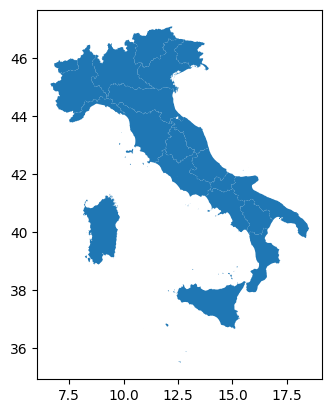

In [30]:
gdf = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/ITA_adm/ITA_adm1.shp')
print(gdf)
gdf.plot()

In [31]:
print(gdf.VARNAME_1[0])

Abruzos|Abruzzen|Abruzzes|Abruzzi


In [41]:
print(gdf.geometry[0])

POLYGON ((13.915415763854924 42.89561080932623, 13.915415763854924 42.895416259765625, 13.915694236755314 42.895416259765625, 13.915694236755314 42.894859313964844, 13.915971755981445 42.894859313964844, 13.915971755981445 42.89439392089855, 13.915971755981445 42.89402770996105, 13.91621398925787 42.89402770996105, 13.917362213134766 42.89402770996105, 13.917362213134766 42.89374923706066, 13.918749809265194 42.89374923706066, 13.918749809265194 42.89347076416027, 13.919028282165584 42.89347076416027, 13.919028282165584 42.89263916015631, 13.919305801391658 42.89263916015631, 13.919305801391658 42.892082214355526, 13.919584274292049 42.892082214355526, 13.919584274292049 42.89097213745117, 13.919305801391658 42.89097213745117, 13.919305801391658 42.889305114746094, 13.919584274292049 42.889305114746094, 13.919584274292049 42.88791656494152, 13.919859886169547 42.88791656494152, 13.919859886169547 42.886249542236385, 13.920138359069938 42.886249542236385, 13.920138359069938 42.884860992

In [33]:
gdf.geometry[0].bounds

(13.01940631866455, 41.68308258056635, 14.783889770507926, 42.89573669433605)

In [34]:
xxx = gdf.geometry[0].bounds
list(xxx)

[13.01940631866455, 41.68308258056635, 14.783889770507926, 42.89573669433605]

In [35]:
print(gdf.geometry[0])

POLYGON ((13.915415763854924 42.89561080932623, 13.915415763854924 42.895416259765625, 13.915694236755314 42.895416259765625, 13.915694236755314 42.894859313964844, 13.915971755981445 42.894859313964844, 13.915971755981445 42.89439392089855, 13.915971755981445 42.89402770996105, 13.91621398925787 42.89402770996105, 13.917362213134766 42.89402770996105, 13.917362213134766 42.89374923706066, 13.918749809265194 42.89374923706066, 13.918749809265194 42.89347076416027, 13.919028282165584 42.89347076416027, 13.919028282165584 42.89263916015631, 13.919305801391658 42.89263916015631, 13.919305801391658 42.892082214355526, 13.919584274292049 42.892082214355526, 13.919584274292049 42.89097213745117, 13.919305801391658 42.89097213745117, 13.919305801391658 42.889305114746094, 13.919584274292049 42.889305114746094, 13.919584274292049 42.88791656494152, 13.919859886169547 42.88791656494152, 13.919859886169547 42.886249542236385, 13.920138359069938 42.886249542236385, 13.920138359069938 42.884860992

### Italy

In [36]:
polygons, points = get_geometries((13.09844970703125, 42.84777884235987), (14.753265380859375, 41.67906622516409), 0.0174532925199433)

##country_geom is a shapely polygon with country boundaries
country_geom = wkt.loads(str(gdf.geometry[0]))

intersecting_polygons = []
intersecting_points = []

### for polygon in polygons:
for polygon in polygons:
    if polygon.intersects(country_geom):
        intersecting_polygons.append(polygon)

### for point in points:
#     if country_geom.contains(point):
#         intersecting_points.append(point)

polygon_grid = MultiPolygon(intersecting_polygons)
# point_grid = MultiPoint(intersecting_points)

#grids are shapely geometries. You can output them as WKT format
# print(point_grid.wkt)
print(polygon_grid.wkt)

MULTIPOLYGON (((13.936207747988561 41.67906622516409, 13.936207747988561 41.69651951768404, 13.918754455468617 41.69651951768404, 13.918754455468617 41.67906622516409, 13.936207747988561 41.67906622516409)), ((13.953661040508505 41.67906622516409, 13.953661040508505 41.69651951768404, 13.936207747988561 41.69651951768404, 13.936207747988561 41.67906622516409, 13.953661040508505 41.67906622516409)), ((13.97111433302845 41.67906622516409, 13.97111433302845 41.69651951768404, 13.953661040508505 41.69651951768404, 13.953661040508505 41.67906622516409, 13.97111433302845 41.67906622516409)), ((13.988567625548393 41.67906622516409, 13.988567625548393 41.69651951768404, 13.97111433302845 41.69651951768404, 13.97111433302845 41.67906622516409, 13.988567625548393 41.67906622516409)), ((14.006020918068337 41.67906622516409, 14.006020918068337 41.69651951768404, 13.988567625548393 41.69651951768404, 13.988567625548393 41.67906622516409, 14.006020918068337 41.67906622516409)), ((14.023474210588281 

### Sweden

    ID_0  ISO  NAME_0  ID_1           NAME_1    TYPE_1 ENGTYPE_1  NL_NAME_1  \
0    222  SWE  Sweden     1     Östergötland  Laen|län    County        NaN   
1    222  SWE  Sweden     2         Blekinge  Laen|län    County        NaN   
2    222  SWE  Sweden     3          Dalarna  Laen|län    County        NaN   
3    222  SWE  Sweden     4        Gävleborg  Laen|län    County        NaN   
4    222  SWE  Sweden     5          Gotland  Laen|län    County        NaN   
5    222  SWE  Sweden     6          Halland  Laen|län    County        NaN   
6    222  SWE  Sweden     7         Jämtland  Laen|län    County        NaN   
7    222  SWE  Sweden     8        Jönköping  Laen|län    County        NaN   
8    222  SWE  Sweden     9           Kalmar  Laen|län    County        NaN   
9    222  SWE  Sweden    10        Kronoberg  Laen|län    County        NaN   
10   222  SWE  Sweden    11       Norrbotten  Laen|län    County        NaN   
11   222  SWE  Sweden    12           Orebro  Laen|l

<AxesSubplot: >

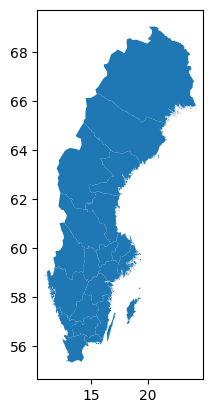

In [37]:
gdfSWE = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/SWE_adm/SWE_adm1.shp')
print(gdfSWE)
gdfSWE.plot()

In [38]:
print(gdfSWE.VARNAME_1[17])

Västerbottens län


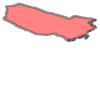

In [39]:
gdfSWE.geometry[17]

In [40]:
polygons, points = get_geometries((14.3975830078125, 66.35072956836751), (21.5277099609375, 63.30774816450429), 0.0174532925199433)

##country_geom is a shapely polygon with country boundaries
country_geom = wkt.loads(str(gdfSWE.geometry[17])) # Västerbottens County

intersecting_polygons = []
intersecting_points = []

### for polygon in polygons:
for polygon in polygons:
    if polygon.intersects(country_geom):
        intersecting_polygons.append(polygon)

### for point in points:
#     if country_geom.contains(point):
#         intersecting_points.append(point)

polygon_grid = MultiPolygon(intersecting_polygons)
# point_grid = MultiPoint(intersecting_points)

#grids are shapely geometries. You can output them as WKT format
# print(point_grid.wkt)
# print(polygon_grid.wkt)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 478, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 73, in rasmgr_keep_alive
    return stub.KeepAlive(make_rasmgr_keep_alive_req(cuuid), _TIMEOUT_SECONDS)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "pThe client with client ID 1ad82c96-2b54-4a84-ba7e-ebd32ba81851 does

In [19]:
polygon_grid.wkt

'MULTIPOLYGON (((19.49394442363579 63.39501462710402, 19.49394442363579 63.412467919623964, 19.476491131115846 63.412467919623964, 19.476491131115846 63.39501462710402, 19.49394442363579 63.39501462710402)), ((19.51139771615573 63.39501462710402, 19.51139771615573 63.412467919623964, 19.49394442363579 63.412467919623964, 19.49394442363579 63.39501462710402, 19.51139771615573 63.39501462710402)), ((19.459037838595904 63.412467919623964, 19.459037838595904 63.42992121214391, 19.441584546075962 63.42992121214391, 19.441584546075962 63.412467919623964, 19.459037838595904 63.412467919623964)), ((19.476491131115846 63.412467919623964, 19.476491131115846 63.42992121214391, 19.459037838595904 63.42992121214391, 19.459037838595904 63.412467919623964, 19.476491131115846 63.412467919623964)), ((19.49394442363579 63.412467919623964, 19.49394442363579 63.42992121214391, 19.476491131115846 63.42992121214391, 19.476491131115846 63.412467919623964, 19.49394442363579 63.412467919623964)), ((19.51139771

## Section 4: Array to Geospatial Coordinates

### Calculating a Regular Grid

A regular grid does not equal a regular grid across projections. The latitude/longitude pairs, which is a polar coordinate system measured in degrees on an approximation of Earth's surface shape. In (EPSG:4326) projection lat/lon distances are not measured in meters/kilometers/miles, but rather in degrees.

Furthermore, Iif I calculate a grid with its "horizontal" steps being parallel to the equator (i.e. latitudes). For other grids (for example rotated rectangular grids, verticals being parallel to longitudes, etc.) one needs to spend more effort transforming input shapes.

Ask yourself: Do you want to create a regularly spaced grid in degrees or in meters?

* **A grid in degrees**

If you want it in degrees, you can simply iterate:

```
stepsize = 0.001
for x in range(lonmin, lonmax, stepsize):
    for y in range(latmin, latmax, stepsize):
        yield (x, y)
        
```

**Note**: The length in meters of a step in degrees is not the same across Earth's surface. For example, 0.001 delta degrees of latitude close to the equator covers a different distance in meters on the surface than it does close to the poles.


https://calgary.rasc.ca/latlong.htm

In [14]:
GetGeoInfo('/home/arkaghosh/Downloads/RAS_DATA/MOD11A1.006_LST_Night_1km_doy20170101_aid0001.tif')

((-179.15833331724446,
  0.008333333332584979,
  0.0,
  88.31666665873561,
  0.0,
  -0.008333333332584979),
 <osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x7fcd127e12d0> >)

In [15]:
print(info) 

Driver: GTiff/GeoTIFF
Files: /home/arkaghosh/Downloads/RAS_DATA/MOD11A1.006_LST_Night_1km_doy20170101_aid0001.tif
       /home/arkaghosh/Downloads/RAS_DATA/MOD11A1.006_LST_Night_1km_doy20170101_aid0001.tif.aux.xml
Size is 43099, 20757
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.158333317244455,88.316666658735613)
Pixel Size = (0.008333333332585,-0.008333333332585)
Metadata:
  add_offset=0
  AREA_OR_POINT=Area
  scale_factor=0.02
  units=Kelvin
Image Structure Me

In [16]:
### Known Parameters for Data array
dataARRAY_origin = [(0,0),(43099, 20757)]
pixelSize = (0.008333333332585,-0.008333333332585)

### Known Parameters for Geo array
geoOrigin = (-179.158333317244455,88.316666658735613)
spacingDEGREE = 0.0174532925199433

#### BBOX
latmin = -84.6583333
latmax = 88.3166667
lonmin = -179.1583333
lonmax = 180.0000000

In [17]:
nrows,ncols = (43099, 20757) #np.shape(worldDATA)
xres = (latmax-latmin)/float(ncols)
yres = (lonmax-lonmin)/float(nrows)
geotransform=(latmin,xres,0,lonmax,0, -yres)

In [18]:
geotransform

(-84.6583333, 0.008333333333333333, 0, 180.0, 0, -0.008333333332559919)

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 478, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 73, in rasmgr_keep_alive
    return stub.KeepAlive(make_rasmgr_keep_alive_req(cuuid), _TIMEOUT_SECONDS)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "pThe client with client ID 4326dd52-85fe-4c92-a0d0-6fe307342667 does

## Section 5: Queires 

In [ ]:
for c in (AIR_TEMP_X) return max(clip(c, MULTIPOLYGON((( -20.4270 131.6931, -28.4204 124.1895,-27.9944 139.4604, -26.3919 129.0015 )),(( -20.4270 131.6931, -19.9527 142.4268,-27.9944 139.4604, -21.8819 40.5151)) ) ))

In [24]:
Q1 = "select clip(w[1, 0:*, 0:10000], polygon((0 0, 20 -10 , 60 20 , 30 40, 0 0))) from LST_03_GeoTIFF as w"
query2array(Q1)

(61, 41)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

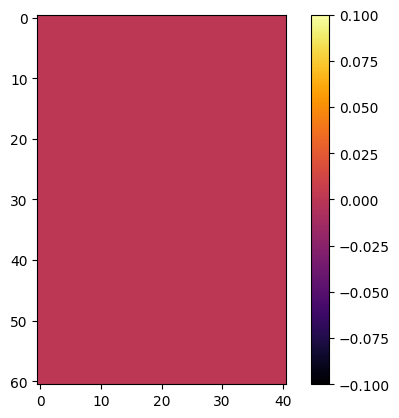

(61, 41)
<class 'numpy.ndarray'>


In [25]:
arrayDISP(Q1)

In [33]:
Q2 = "select clip(w[1, 0:*, 0:20000], polygon((0 0, 20 -10 , 10000 20000 , 3000 4000, 0 0))) from LST_03_GeoTIFF as w"
arrayDISP(Q2)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "recvmsg:Connection reset by peer"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:7003 {grpc_message:"recvmsg:Connection reset by peer", grpc_status:14, created_time:"2023-02-20T22:50:48.626068323+05:30"}"
>